In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.float_format', '{:.4f}'.format)
%precision 4
%config InlineBackend.figure_format = 'retina'

import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

In [2]:
names = {
    'lump': 'Lump Sum',
    'dca': 'Dollar Cost Averaging',
    'lump_dca': 'Ratio of Lump Sum to Dollar Cost Averaging'
}

In [3]:
ff = (
    pdr.get_data_famafrench(
        symbols='F-F_Research_Data_Factors',
        start='1900',
        session=session
    )
    [0]
    .div(100)
    .assign(Mkt=lambda x: x['Mkt-RF'] + x['RF'])
    [['Mkt', 'RF']]
)

# Consider only 1999 through today

In [4]:
def lump_once(x, total, pmt):
    _df = x.copy()
    _df[['lump', 'dca_mkt', 'dca_cash']] = np.nan, np.nan, np.nan

    for i, (mkt, rf) in _df[['Mkt', 'RF']].iterrows():
        if i==_df.index[0]:
            lump_lag = total
            dca_mkt_lag = pmt
            dca_cash_lag = total - pmt

        lump = lump_lag*(1 + mkt)
        dca_mkt = dca_mkt_lag*(1 + mkt)
        dca_cash = dca_cash_lag*(1 + rf)

        _df.loc[i, ['lump', 'dca_mkt', 'dca_cash']] = (lump, dca_mkt, dca_cash)

        lump_lag = lump
        dca_mkt_lag = dca_mkt + min(pmt, dca_cash)
        dca_cash_lag = dca_cash - min(pmt, dca_cash)
        
    _df['dca'] = _df['dca_mkt'] + _df['dca_cash']
    
    return _df

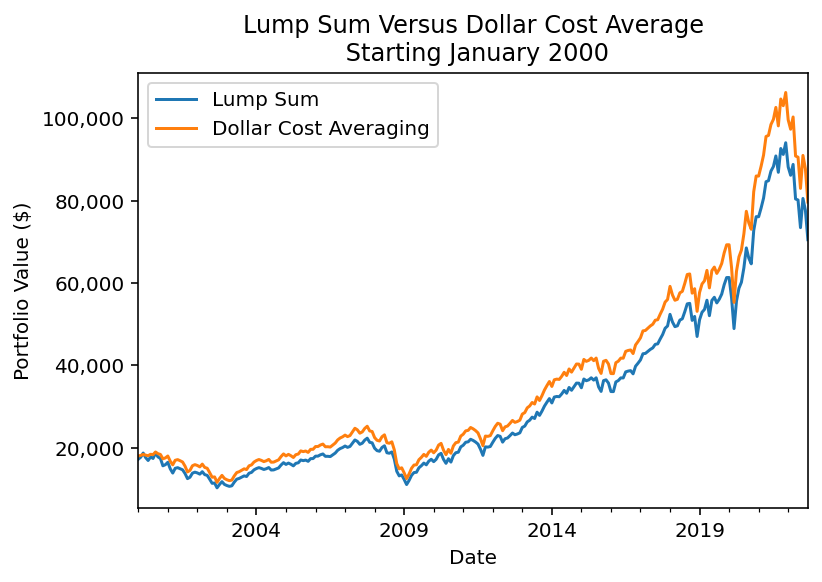

In [5]:
date = '2000-01'
(
    ff
    .loc[date:]
    .pipe(lump_once, total=18_000, pmt=1_000)
    [['lump', 'dca']]
    .rename(columns=names)
    .plot()
)
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Portfolio Value ($)')
plt.title(f'Lump Sum Versus Dollar Cost Average\n Starting {pd.to_datetime(date).strftime("%B %Y")}')
plt.show()

# Can you find a period that reverses your question 1 conclusion?

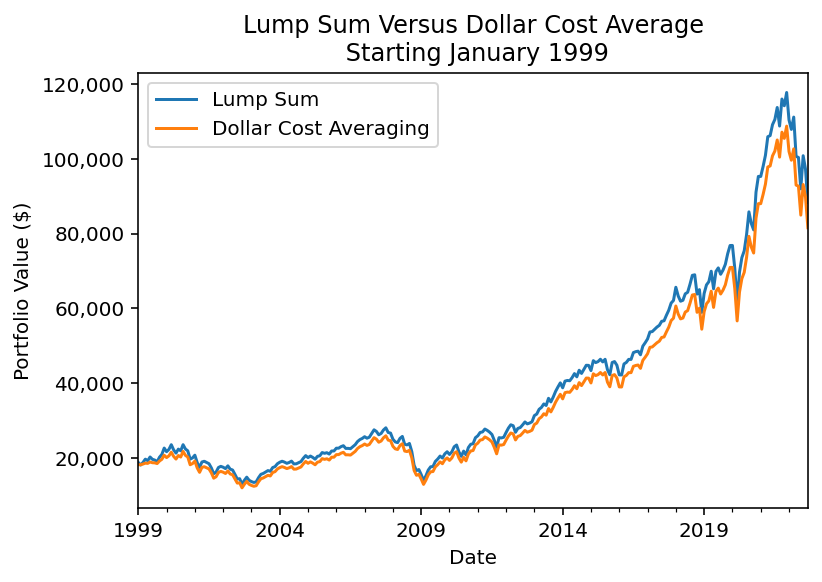

In [6]:
date = '1999-01'
(
    ff
    .loc[date:]
    .pipe(lump_once, total=18_000, pmt=1_000)
    [['lump', 'dca']]
    .rename(columns=names)
    .plot()
)
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Portfolio Value ($)')
plt.title(f'Lump Sum Versus Dollar Cost Average\n Starting {pd.to_datetime(date).strftime("%B %Y")}')
plt.show()

# Consider all full years from 1927 through 2021

In [7]:
def lump_yearly(x, yearly):
    _df = x.copy()
    _df[['lump', 'dca_mkt', 'dca_cash']] = np.nan, np.nan, np.nan

    for i, (mkt, rf) in _df[['Mkt', 'RF']].iterrows():
        if i==_df.index[0]:
            lump_lag = 0
            dca_mkt_lag = 0
            dca_cash_lag = 0

        if i.month==1:
            lump_lag += yearly
            dca_mkt_lag += yearly / 12
            dca_cash_lag += 11 * yearly / 12
            
        lump = lump_lag*(1 + mkt)
        dca_mkt = dca_mkt_lag*(1 + mkt)
        dca_cash = dca_cash_lag*(1 + rf)

        _df.loc[i, ['lump', 'dca_mkt', 'dca_cash']] = (lump, dca_mkt, dca_cash)

        lump_lag = lump
        dca_mkt_lag = dca_mkt + yearly / 12
        dca_cash_lag = dca_cash - yearly / 12

        if i.month==11:
            dca_mkt_lag += dca_cash_lag
            dca_cash_lag = 0
        
    _df['dca'] = _df['dca_mkt'] + _df['dca_cash']
    
    return _df

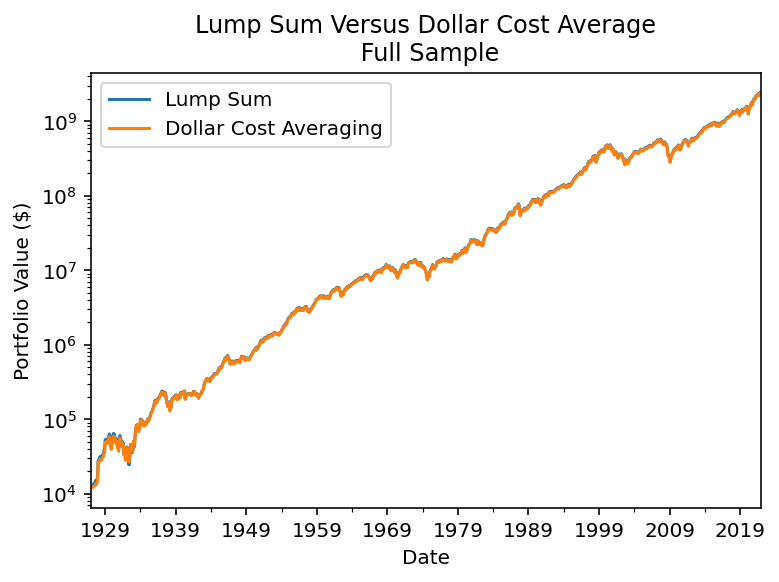

In [8]:
(
    ff
    .loc['1927':'2021']
    .pipe(lump_yearly, yearly=12_000)
    [['lump', 'dca']]
    .rename(columns=names)
    .plot()
)
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Portfolio Value ($)')
plt.title(f'Lump Sum Versus Dollar Cost Average\n Full Sample')
plt.semilogy()
plt.show()

# Consider all available 20-year holding periods

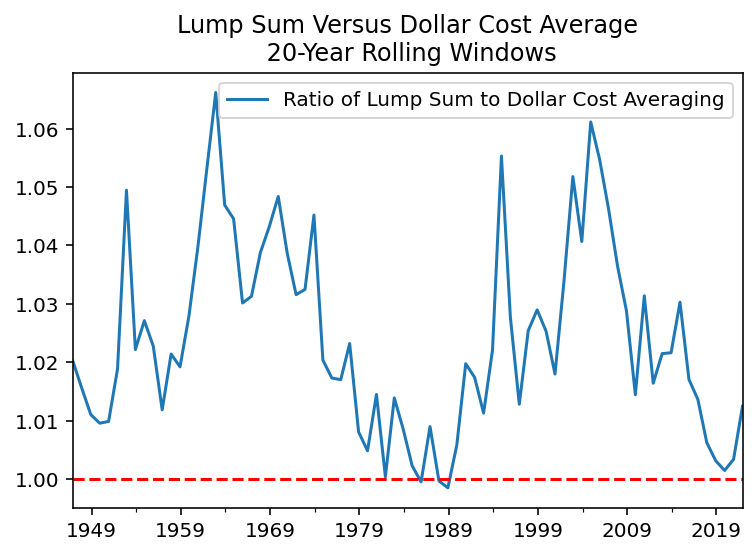

In [9]:
window = 20
dfs = [
    ff.loc[str(y-window+1):str(y)].pipe(lump_yearly, yearly=18_000) 
    for y 
    in range(1927+window-1, 2022)
]
(
    pd.concat(
        objs=[
            x.iloc[-1] 
            for x 
            in dfs
        ], 
        axis=1)
    .T
    .assign(lump_dca=lambda x: x['lump'].div(x['dca']))
    [['lump_dca']]
    .rename(columns=names)
    .plot()
)
plt.axhline(y=1, linestyle='dashed', color='red')
plt.title(f'Lump Sum Versus Dollar Cost Average\n 20-Year Rolling Windows')
plt.show()

# Which investing strategy is better overall, LS or DCA?